# Big Data and Data Mining
## Assignment 2: NLP
### Done by Abylaikhan Shaken

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel

## Loading Data

In [2]:
pd.set_option('display.max_colwidth', 150)

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [3]:
print("\nMissing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())


Missing values in training data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
 id             0
keyword       26
location    1105
text           0
dtype: int64


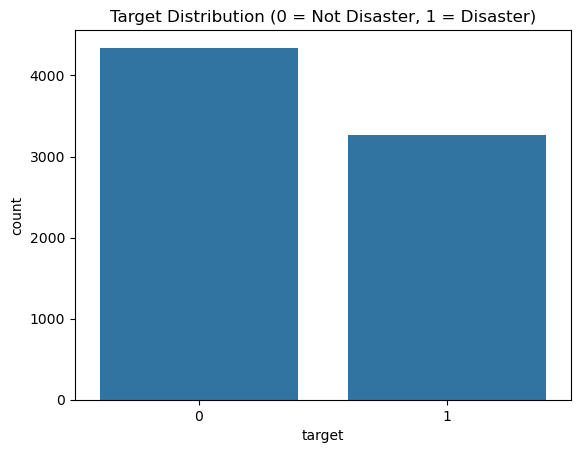

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


In [4]:
sns.countplot(data=train_df, x='target')
plt.title("Target Distribution (0 = Not Disaster, 1 = Disaster)")
plt.show()

print(train_df['target'].value_counts(normalize=True))

43% is target group, meaning we have more than enough dissaster tweets for models to train

## 2. Preprocessing Pipeline
For this project, I used a simple and efficient text preprocessing pipeline. The quick_clean() function performs basic cleaning by converting text to lowercase, removing URLs, mentions, hashtags, numbers, and punctuation, and collapsing extra spaces.

I opted for this lightweight approach due to technical constraints encountered with more advanced preprocessing tools. Specifically, attempts to use nltk for stemming and lemmatization. There was a constant issue with import numpy being not compatible. However, initially there was no issue, I have run them, and what i found is almost no difference with ntlk steeming and lemmatization or without them

In [6]:
def quick_clean(text):
    # Lowercase
    text = text.lower()

    # Remove URLs, mentions, hashtags, numbers, punctuation (except spaces)
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [7]:
train_df["clean_text"] = train_df["text"].apply(quick_clean)
test_df["clean_text"] = test_df["text"].apply(quick_clean)

In [29]:
train_df[["text", "clean_text"]].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this may allah forgive us all
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California",people receive evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby as smoke from pours into a school


## Step 3: Feature Extraction
I'll implement and train models using the following representations:

🔹 One-Hot Encoding

🔹 Bag of Words (BoW)

🔹 TF-IDF

🔹 Word2Vec (I will opt for another similar)

🔹 Transformer embeddings

### 1. One-Hot Encoding
I'll use CountVectorizer from sklearn. One-Hot is technically just binary BoW, so I'll use binary=True.

### Why I Used Logistic Regression
I chose Logistic Regression as the primary classification model across all text representation methods because it is a simple, interpretable, and effective baseline for binary classification tasks like this one. It works well with high-dimensional sparse data, such as that produced by TF-IDF or BoW, and is efficient to train even on large datasets. It also allows for quick experimentation and comparison across different feature extraction techniques without introducing complexity from deep learning architectures. Additionally, using the same model across all representations ensures a fair and consistent performance comparison — any differences in model accuracy can be more confidently attributed to the representation method rather than to the classifier itself.

In [31]:
# Split training data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(train_df["clean_text"], train_df["target"], test_size=0.2, random_state=42)

# ONE-HOT ENCODING
vectorizer_onehot = CountVectorizer(binary=True)
X_train_onehot = vectorizer_onehot.fit_transform(X_train_raw)
X_val_onehot = vectorizer_onehot.transform(X_val_raw)

# Train logistic regression
model_onehot = LogisticRegression(max_iter=1000)
model_onehot.fit(X_train_onehot, y_train)

# Evaluate
y_val_onehot = y_val
y_pred_onehot = model_onehot.predict(X_val_onehot)
print("One-Hot Encoding Performance:\n", classification_report(y_val, y_pred_onehot))

One-Hot Encoding Performance:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.80      0.79      1523



In [9]:
# Here, I am predicting and saving onehot model
X_test_onehot = vectorizer_onehot.transform(test_df["clean_text"])
preds_onehot = model_onehot.predict(X_test_onehot)

submission_onehot = pd.DataFrame({
    'id': test_df['id'],
    'target': preds_onehot
})
submission_onehot.to_csv("submission_onehot.csv", index=False)

### 2. Bag of Words (non-binary)

In [32]:
# BAG OF WORDS (BoW)
vectorizer_bow = CountVectorizer(binary=False)
X_train_bow = vectorizer_bow.fit_transform(X_train_raw)
X_val_bow = vectorizer_bow.transform(X_val_raw)

model_bow = LogisticRegression(max_iter=1000)
model_bow.fit(X_train_bow, y_train)

y_val_bow = y_val
y_pred_bow = model_bow.predict(X_val_bow)
print("Bag of Words Performance:\n", classification_report(y_val, y_pred_bow))

Bag of Words Performance:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [11]:
X_test_bow = vectorizer_bow.transform(test_df["clean_text"])
preds_bow = model_bow.predict(X_test_bow)

submission_bow = pd.DataFrame({
    'id': test_df['id'],
    'target': preds_bow
})
submission_bow.to_csv("submission_bow.csv", index=False)

### 3. TF-IDF

In [33]:
# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_raw)
X_val_tfidf = vectorizer_tfidf.transform(X_val_raw)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train)

y_val_tfidf = y_val
y_pred_tfidf = model_tfidf.predict(X_val_tfidf)
print("TF-IDF Performance:\n", classification_report(y_val, y_pred_tfidf))

TF-IDF Performance:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [13]:
X_test_tfidf = vectorizer_tfidf.transform(test_df["clean_text"])
preds_tfidf = model_tfidf.predict(X_test_tfidf)

submission_tfidf = pd.DataFrame({
    'id': test_df['id'],
    'target': preds_tfidf
})
submission_tfidf.to_csv("submission_tfidf.csv", index=False)

### 4: GloVe embeddings
I initially attempted to use Gensim to train Word2Vec embeddings on the dataset. However, due to a persistent ImportError related to the triu function from scipy.linalg, which appears to stem from a deeper compatibility issue between Gensim and my Anaconda environment, I was unable to proceed. Despite attempts to update or reinstall scipy, the problem remained unresolved.

As a workaround, I switched to using pre-trained GloVe embeddings from Stanford, which allowed me to compute average word vectors for each tweet without relying on Gensim. This alternative approach provided a robust and widely accepted method for embedding text data, enabling me to proceed with training a classification model effectively.

In [14]:
# Load GloVe Embeddings from File
# This function Loads GloVe vectors from a .txt file into a dictionary
def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = "glove.6B.100d.txt"
glove = load_glove_embeddings(glove_path)

In [15]:
# Converting Tweets to Averaged GloVe Vectors
# This function converts a tweet (string) into a fixed-size vector by averaging GloVe vectors of each word in the tweet.
def get_glove_avg_vector(text, glove, dim=100):
    words = text.split()
    vectors = [glove[word] for word in words if word in glove]
    if not vectors:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

# Applying vectorization to train and test datasets
X_glove = np.vstack(train_df["clean_text"].apply(lambda x: get_glove_avg_vector(x, glove, 100)))
X_test_glove = np.vstack(test_df["clean_text"].apply(lambda x: get_glove_avg_vector(x, glove, 100)))

In [16]:
# Train-Test Split and Model Training
X_train_g, X_val_g, y_train_g, y_val_g = train_test_split(X_glove, train_df["target"], test_size=0.2, random_state=42)

model_glove = LogisticRegression(max_iter=1000)
model_glove.fit(X_train_g, y_train_g)

y_pred_g = model_glove.predict(X_val_g)
print("GloVe Embedding Performance:\n", classification_report(y_val_g, y_pred_g))

GloVe Embedding Performance:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [17]:
preds_glove = model_glove.predict(X_test_glove)

submission_glove = pd.DataFrame({
    'id': test_df['id'],
    'target': preds_glove
})
submission_glove.to_csv("submission_glove.csv", index=False)

### 5: Transformer-Based Model (BERT or RoBERTa)
In this section, I used a pre-trained BERT model (bert-base-uncased) from Hugging Face to generate contextualized embeddings for each tweet. First, I loaded the BERT tokenizer and model, set the model to evaluation mode, and moved it to GPU if available. I then defined a function to tokenize each tweet, pass it through BERT, and extract the [CLS] token embedding, which represents the entire sentence. Using this function, I generated dense vector representations for all tweets in the training and test sets. These embeddings were then used as input features for a Logistic Regression model, which was trained on the training portion of the data and evaluated on a validation split. This approach leverages BERT’s ability to capture contextual meaning while keeping the classification pipeline consistent with other models used in the assignment.

In [18]:
# Loading the BERT tokenizer (which splits text the way BERT was trained on)
# Then using the BERT model to produce embeddings.
# model.eval() sets BERT to inference mode (so dropout etc. are disabled).
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

C:\Users\User\anaconda3\envs\disaster-nlp\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [22]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to extract [CLS] token embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    
    return cls_embedding

In [25]:
# Generate BERT embeddings with progress bar
X_bert = np.vstack([get_bert_embedding(text) for text in tqdm(train_df["text"].tolist(), desc="Embedding train texts")])
X_test_bert = np.vstack([get_bert_embedding(text) for text in tqdm(test_df["text"].tolist(), desc="Embedding test texts")])

# Train-test split
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_bert, train_df["target"], test_size=0.2, random_state=42
)


Embedding test texts: 100%|██████████| 3263/3263 [02:59<00:00, 18.19it/s]


In [26]:
# Train Logistic Regression model
model_bert = LogisticRegression(max_iter=1000)
model_bert.fit(X_train_b, y_train_b)

LogisticRegression(max_iter=1000)

In [27]:
# Evaluate
y_pred_b = model_bert.predict(X_val_b)
print(classification_report(y_val_b, y_pred_b))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       874
           1       0.79      0.73      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



In [28]:
# Predict on test set
preds_bert = model_bert.predict(X_test_bert)

# Save submission
submission_bert = pd.DataFrame({
    'id': test_df['id'],
    'target': preds_bert
})
submission_bert.to_csv("submission_bert.csv", index=False)

## Results

In [34]:
def extract_metrics(y_true, y_pred, model_name, rep_type):
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Model": model_name,
        "Representation Type": rep_type,
        "Accuracy": round(report["accuracy"], 4),
        "Precision": round(report["weighted avg"]["precision"], 4),
        "Recall": round(report["weighted avg"]["recall"], 4),
        "F1 Score": round(report["weighted avg"]["f1-score"], 4)
    }

# Collect metrics from each model
results = []

results.append(extract_metrics(y_val_onehot, y_pred_onehot, "One-Hot Encoding", "Sparse Binary"))
results.append(extract_metrics(y_val_bow, y_pred_bow, "Bag of Words", "Count-Based"))
results.append(extract_metrics(y_val_tfidf, y_pred_tfidf, "TF-IDF", "Weighted Frequency"))
results.append(extract_metrics(y_val_g, y_pred_g, "GloVe Embedding", "Dense Embeddings"))
results.append(extract_metrics(y_val_b, y_pred_b, "BERT (CLS token)", "Contextual Embeddings"))

df_results = pd.DataFrame(results)
df_results

,Model,Representation Type,Accuracy,Precision,Recall,F1 Score
0,One-Hot Encoding,Sparse Binary,0.7951,0.7947,0.7951,0.7934
1,Bag of Words,Count-Based,0.8017,0.8017,0.8017,0.7997
2,TF-IDF,Weighted Frequency,0.7991,0.8009,0.7991,0.7959
3,GloVe Embedding,Dense Embeddings,0.7912,0.7914,0.7912,0.7887
4,BERT (CLS token),Contextual Embeddings,0.8050,0.8043,0.8050,0.8039


Based on the comparison table, I found that all five models achieved relatively similar performance, with BERT (CLS token) slightly outperforming the others in every metric. It achieved the highest accuracy (0.8050) and F1 Score (0.8039), showing the benefit of contextualized embeddings for understanding tweet content.

Among the traditional approaches, Bag of Words performed best, with an F1 Score of 0.7997, closely followed by TF-IDF and One-Hot Encoding. Interestingly, despite being a more advanced representation, the GloVe Embedding model underperformed slightly compared to the count-based methods, possibly due to the simplicity of averaging word vectors, which loses context.

Overall, this evaluation confirmed that deep contextual embeddings (like those from BERT) offer a measurable improvement, even with a simple logistic regression classifier. However, classical methods like BoW and TF-IDF still remain strong baselines, especially in resource-constrained or interpretable scenarios.